In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from lyapynov import ContinuousDS, DiscreteDS
from lyapynov import mLCE, LCE, CLV, ADJ

## 1) Continuous dynamical systems
Let us illustrate the computation of Lyapunov exponents and covariant vectors on a continuous dynamical system with the Lorenz63 system. This model is described by the following equations:
$$
\left \{
    \begin{array}{ll}
        \dot{x} = \sigma \left(y - x\right)\\
        \dot{y} = x\left(\rho - z\right) - y \\
        \dot{z} = xy - \beta z
    \end{array}
\right.
$$

<div style="display: flex; justify-content: center;">
    <img src="images/Lorenz63.png" alt="Lorenz" />
</div>

In [3]:
# Definition of a continuous dynamical system, here Lorenz63.
sigma = 10.
rho = 28.
beta = 8./3.
x0 = np.array([1.5, -1.5, 20.])
t0 = 0.
dt = 1e-2

def f(x,t):
    res = np.zeros_like(x)
    res[0] = sigma*(x[1] - x[0])
    res[1] = x[0]*(rho - x[2]) - x[1]
    res[2] = x[0]*x[1] - beta*x[2]
    return res

def jac(x,t):
    res = np.zeros((x.shape[0], x.shape[0]))
    res[0,0], res[0,1] = -sigma, sigma
    res[1,0], res[1,1], res[1,2] = rho - x[2], -1., -x[0]
    res[2,0], res[2,1], res[2,2] = x[1], x[0], -beta
    return res

Lorenz63 = ContinuousDS(x0, t0, f, jac, dt)
Lorenz63.forward(10**6, False)

### a) Maximum 1-LCE (mLCE)

In [4]:
# Compute mLCE
mLCE, history = mLCE(Lorenz63, 0, 10**6, True)

In [5]:
# Print mLCE
print("mLCE: {:.3f}".format(mLCE))

mLCE: 0.906


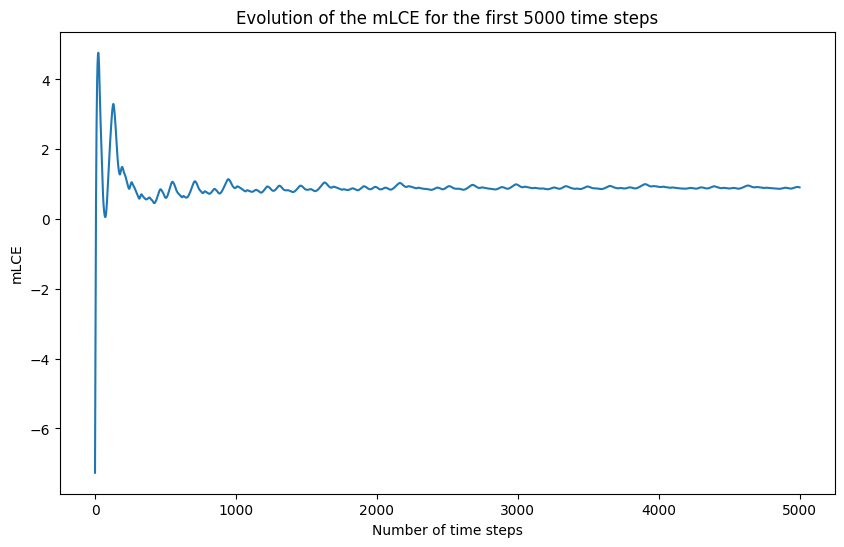

In [6]:
# Plot of mLCE evolution
plt.figure(figsize = (10,6))
plt.plot(history[:5000])
plt.xlabel("Number of time steps")
plt.ylabel("mLCE")
plt.title("Evolution of the mLCE for the first 5000 time steps")
plt.show()

### b) LCE

In [7]:
# Computation of LCE
LCE, history = LCE(Lorenz63, 3, 0, 10**6, True)

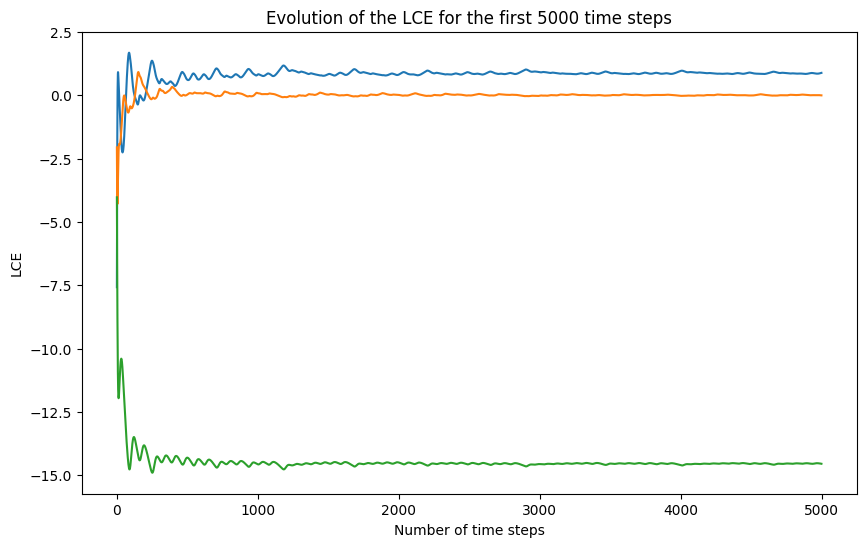

In [8]:
# Plot of LCE
plt.figure(figsize = (10,6))
plt.plot(history[:5000])
plt.xlabel("Number of time steps")
plt.ylabel("LCE")
plt.title("Evolution of the LCE for the first 5000 time steps")
plt.show()

### c) CLV

In [8]:
# Compute CLV
CLV, traj, checking_ds = CLV(Lorenz63, 3, 0, 10**5, 10**6, 10**5, True, check = True)

In [9]:
# Check CLV
LCE_check = np.zeros((Lorenz63.dim,))
for i in range(len(CLV)):
    W = CLV[i]
    init_norm = np.linalg.norm(W, axis = 0)
    W = checking_ds.next_LTM(W)
    norm = np.linalg.norm(W, axis = 0)
    checking_ds.forward(1, False)
    LCE_check += np.log(norm / init_norm) / checking_ds.dt
LCE_check = LCE_check / len(CLV)

print("Average of first local Lyapunov exponent: {:.3f}".format(LCE_check[0]))
print("Average of second local Lyapunov exponent: {:.3f}".format(LCE_check[1]))
print("Average of third local Lyapunov exponent: {:.3f}".format(LCE_check[2]))

Average of first local Lyapunov exponent: 0.904
Average of second local Lyapunov exponent: 0.000
Average of third local Lyapunov exponent: -14.571


### d) Adjoints of CLV

In [10]:
# Compute adjoints of CLV
ADJs = ADJ(CLV)

In [11]:
# Theta^{T}(t) * Gamma(t) = D(t)
np.transpose(ADJs[89547]) @ CLV[89547]

array([[6.94222764e-01, 1.71881713e-17, 4.18689614e-17],
       [9.23903337e-18, 6.89116192e-01, 2.21459907e-17],
       [2.22593548e-17, 1.72794732e-17, 8.96894256e-01]])

## 2) Discrete dynamical systems
Let us illustrate the computation of Lyapunov exponents and covariant vectors on a discrete dynamical system using the Coupled Map Lattices (CML). This dynamic of the lattice is given by:
$$
u_{i}^{(n+1)} = F(\mathbf{u}^{(n)}) = f(u_{i}^{(n)}) + \frac{\varepsilon}{2} \bigl( f(u_{i+1}^{(n)}) - 2f(u_{i}^{(n)}) + f(u_{i-1}^{(n)}) \bigr)
$$

<div style="display: flex; justify-content: center;">
    <img src="images/CML.png" alt="CML" />
</div>

In [ ]:
# Definition of a discrete dynamical system, here a CML.
a = 1.1
eps = 0.65
N = 128
x0 = np.random.rand(N)
x0 = (x0 / np.sum(x0)) * 1.2
t0 = 0

def f(x):
    return 1. - a * np.abs(x)
    
def f_prime(x):
    if (x < 0.):
        return a
    elif (x > 0.):
        return a
    else:
        return 0.

def F(U,t):
    res = np.zeros_like(U)
    N = len(U)
    for i in range(N):
        previous, nxt = (i-1)%N, (i+1)%N
        single_tent = f(U[i])
        diffusion = (eps / 2.) * (f(U[previous]) - 2*single_tent + f(U[nxt]))
        res[i] = single_tent + diffusion
    return res

def tri_diag(N, a, b, c):
    if (N >= 3):
        res = np.zeros((N,N))
        np.fill_diagonal(res, a)
        np.fill_diagonal(res[:, 1:], b)
        np.fill_diagonal(res[1:], c)
        res[0,-1] = c
        res[-1,0] = b
        return res
    else:
        print("Dimension should be greater or equal to 3.")
    
def jac(U,t):
    N = len(U)
    if (N == 1):
        res =  np.array([f_prime(U[0])])
    elif (N == 2):
        res = np.zeros((N,N))
        res[0,0] = f_prime(U[0]) * (1. - eps)
        res[1,1] = f_prime(U[1]) * (1. - eps)
        res[0,1] = f_prime(U[1]) * eps
        res[1,0] = f_prime(U[0]) * eps
    else:
        A = np.zeros((N,N))
        A += tri_diag(N, 1. - eps, eps/2., eps/2.)
        prime_vect = np.expand_dims(np.asarray([f_prime(U[i]) for i in range(N)]), axis = 1)
        B = np.ones((N,1)) @ np.transpose(prime_vect)
        res = np.multiply(A, B)
        return res

CML = DiscreteDS(x0, t0, F, jac)
CML.forward(10**6, False)

Since the computation of the covariant vectors is costly and time-consuming (because of the size of the system), we only compute the LCE here.

In [6]:
# Computation of LCE
LCE = LCE(CML, N, 0, 10**6, False)

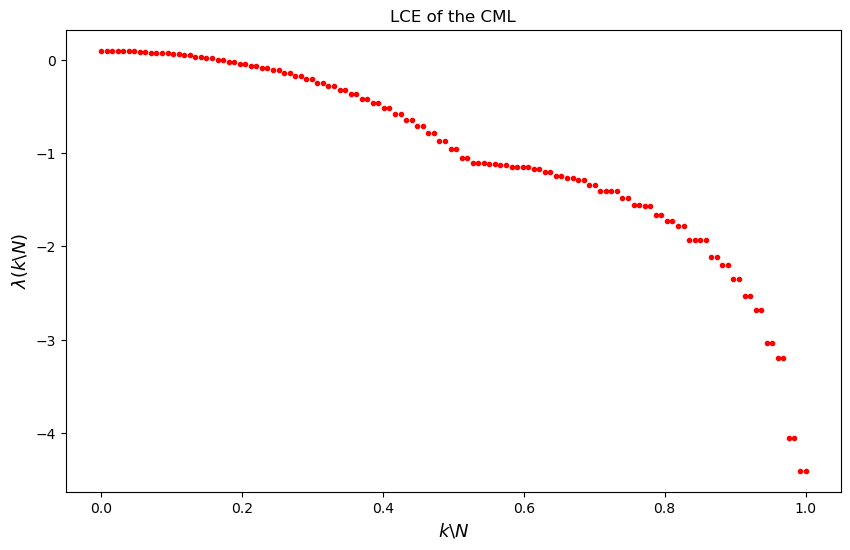

In [11]:
# Plot of LCE
x = np.asarray([(i/(N-1)) for i in range(N)])
plt.figure(figsize = (10,6))
plt.plot(x,LCE,'ro', markersize = 3)
plt.xlabel(r'$k \backslash N$', fontsize = 13)
plt.ylabel(r'$\lambda(k \backslash N)$', fontsize = 13)
plt.title("LCE of the CML")
plt.show()